# Recommender systems - Collaborative Filtering

## Global imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from load_mat import load_mat

## Introduction

There are many different algorithms that allows to calculate (predict) products/services that customer might like based on their opinions on other products.

One of the most popular one is **Collaborative Filtering**. It is a method of making automatic predictions on user's preferences based on others people taste/preferences.

The underlying principle behind the algorithm is that if person **A** has the same opinion on issue as person **B**, then person **A** is more likely to have **B**'s opinion on a different issue rather than any other random person.

Putting everything together - collaborative filtering predicts user opinion on an issue based on opinions of other people that had similar opinions on different issues.

## Dataset - reviews

The most important part of the collaborative filtering is (no surprise) - dataset.

In the following example we will load ***/data/ex8_movies.mat*** - it contains matrices **r** and **y**.

r is a matrix indicating whether the given user provided us their rating for a particular movie. It is a matrix of a size number of movies x number of users that contains 1 if user provided a rating, or 0 otherwise.

y is a matrix containing the ratings of each movie provided by each user. It is a matrix of a size number of movies x number of users that contains a number from 0 to 5.

### Visualizing dataset

To simply visualize a dataset, numpy's **imshow** function can be used.

Average rating for movie 1 (Toy Story) is: 3.21


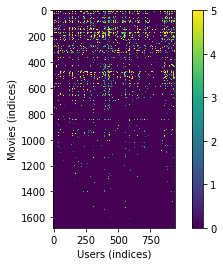

In [2]:
from visualize_matrix import visualize_matrix

r, y = load_mat('./data/ex8_movies.mat', 'R', 'Y')

print(f"Average rating for movie 1 (Toy Story) is: {round(float(np.mean(y[1, r[1, :] == 1])), 2)}")
visualize_matrix(plt, y)
plt.show()

## Dataset - movies

The list of all the movies is defined in ***data/movies.csv*** file. It is a simple CSV file with one column containing movie title.

In [3]:
movies = np.genfromtxt('./data/movies.csv', delimiter='|', dtype=bytes).astype(str)

print('First 5 movies:')
print(movies[0:5])

First 5 movies:
['Toy Story (1995)' 'GoldenEye (1995)' 'Four Rooms (1995)'
 'Get Shorty (1995)' 'Copycat (1995)']


## Cost function

Minimizing $x^{(1)},...,x^{(n_{m})}$ and $\theta^{(1)},...,\theta^{(n_{u})}$ simultanously:

\begin{align}
\min_{\substack{x^{(1)},...,x^{(n_{m})} \\ \theta^{(1)},...,\theta^{(n_{u})}}} J(x^{(1)},...,x^{(n_{m})}, \theta^{(1)},...,\theta^{(n_{u})}) = \dfrac{1}{2} \sum_{(i,j):r(i,j)=1}((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)})^{2} + \dfrac{\lambda}{2} + \sum^{n_{m}}_{i=1}\sum^{n}_{k=1}(x^{(i)}_{k})^{2} + \dfrac{\lambda}{2}\sum^{n_{u}}_{k=1}(\theta^{(j)}_{k})^{2}
\end{align}

## Cost function - implementation

Cost function is the most difficult part - it is part of ***cofi_cost_function.py*** file.

The important part is that minimizing function accept single parameter which has to be 1-D array, therefore we need to roll and un-roll parameters at the beginning and end of the function execution.

In [4]:
def cofi_cost_function(params, y, r, num_users, num_movies, num_features, lambda_param):
    params = array_to_vector(params)
    # Unroll parameters x & theta
    x = np.array(params[0:num_movies * num_features]).reshape((num_movies, num_features), order='F')
    theta = np.array(params[num_movies * num_features:, :]).reshape((num_users, num_features), order='F')

    regularized = ((lambda_param / 2) * np.sum(np.sum(theta ** 2))) + (lambda_param / 2) * np.sum(np.sum(x ** 2))
    cost_j = .5 * np.sum(np.sum(((x @ theta.T - y) * r) ** 2)) + regularized
    x_grad = ((x @ theta.T - y) * r) @ theta + lambda_param * x
    theta_grad = ((x @ theta.T - y) * r).T @ x + lambda_param * theta
    grad = array_to_vector(np.concatenate([x_grad.ravel(order='F'), theta_grad.ravel(order='F')]))
    return cost_j, grad

## (Optional) adding own data

We can add our own *reviews* to see what the algorithm could propose us to watch next.

In [5]:
my_ratings = np.zeros((np.size(movies, 0), 1))

# Toy Story - mark as 5 star movie
my_ratings[0] = 5
# Seven (Se7en)
my_ratings[10] = 4
# Braveheart
my_ratings[21] = 2
# Apollo 13
my_ratings[26] = 5
# Pulp Fiction
my_ratings[55] = 5
# Ace Ventura: Pet Detective
my_ratings[66] = 1
# Flipper
my_ratings[111] = 2
# Apocalypse Now
my_ratings[179] = 4

y = np.append(my_ratings, y, axis=1)
r = np.append((my_ratings != 0).astype(int), r, axis=1)

## Preparing data

As cofi_cost_function takes number of additional arguments, we need to propare those.

**r** and **y** is data collected from users (matlab file). The rest of the parameters can be easily calculated:

In [6]:
num_movies = np.size(movies, 0)
my_ratings = np.zeros((num_movies, 1))
num_users = np.size(y, 1)
num_features = 10

## Normalizing data

As reviews range from 1 to 5, we need to normalize the data so none will have too big impact on calculations.

In [7]:
from normalize_ratings import normalize_ratings

y_norm, y_mean = normalize_ratings(y, r)

## Random x & theta initialization

**x** and **theta** will be calculated by the optimization algorithm, to start with we initialize those randomly.

In [8]:
x = np.random.rand(num_movies, num_features)
theta = np.random.rand(num_users, num_features)
initial_parameters = np.concatenate([x.ravel(order='F'), theta.ravel(order='F')])
lambda_param = 10

## Optimizing function

Having all data in place, we can use minimize function to find optimal **x** and **theta**. In this example I am going to use TNC.

In [9]:
from scipy.optimize import fmin_tnc

from array_to_vector import array_to_vector
from cofi_cost_function import cofi_cost_function

calculated_params = fmin_tnc(func=cofi_cost_function, x0=initial_parameters, args=(y_norm, r, num_users, num_movies, num_features, lambda_param))[0]
calculated_params = array_to_vector(calculated_params)

# Unwrap calculated parameters
calculated_x = np.array(calculated_params[0:num_movies * num_features]).reshape((num_movies, num_features), order='F')
calculated_theta = np.array(calculated_params[num_movies * num_features:, :]).reshape((num_users, num_features), order='F')

## Predictions

After training the dataset, we can use the calculated values of **x** and **theta** to check predictions.

In [10]:
prediction = calculated_x @ calculated_theta.T
my_predictions = np.asmatrix(prediction[:, 0]).T + y_mean
top_my_predictions_indices = np.argpartition(my_predictions, -5, axis=0)[-5:]
top_movies = movies[top_my_predictions_indices.T]
print(f"Your recommended movies: \n{chr(10).join(list(top_movies.ravel()))}")

Your recommended movies: 
Aiqing wansui (1994)
Someone Else's America (1995)
Star Kid (1997)
Entertaining Angels: The Dorothy Day Story (1996)
Saint of Fort Washington, The (1993)
